In [76]:
import numpy as np
import pandas as pd
import tqdm
import matplotlib.pyplot as plt

# Define activation functions and classification functions

In [77]:
def sigmoid(x):
    x = np.clip(x, -500, 500)
    return 1 / (1 + np.exp(-x))

def relu(x):
    return np.maximum(0, x)

def tanh(x):
    return (np.exp(x) - np.exp(-x)) / (np.exp(x) + np.exp(-x))


def softmax(x):
    exp_x = np.exp(x)

    sum_exp_x = np.sum(exp_x)
    softmax_values = exp_x / sum_exp_x

    return softmax_values


# 1. Implement a multi-layer ANN architecture

In [78]:
class ANN_Network:
    def __init__(self, input_size, hidden_sizes,output_size,acti_func,class_func):
        self.input_size = input_size      # dim of input features to be used(4)
        self.hidden_sizes = hidden_sizes  # hidden layers and number of neurons,
                                          # eg:[2,3],two hidden layers,first layer has 2 neurons,second layer has 3 neurons.
        self.output_size = output_size    # output size,can be 1(use sigmod to classify) or 2(use softmax to classify)
        self.acti_func = acti_func        # active function used between input layer and hidden layers ,and between hidden layers
                                          # can be relu or tanh.
        self.class_func = class_func      # classification function,used in output layer,can be sigmod or softmax.
        
        # Initial weights
        self.W = [np.random.uniform(-1, 1, (self.input_size, self.hidden_sizes[0]))]  # input layer and first hidden layer.
        for i in range(len(self.hidden_sizes) - 1):
            self.W.append(np.random.uniform(-1, 1, (self.hidden_sizes[i], self.hidden_sizes[i + 1]))) # hidden layers.
        
        self.W.append(np.random.uniform(-1, 1, (self.hidden_sizes[-1], self.output_size))) # last hidden layer and output layer.
        
        # Initial bias
        self.B = [np.random.uniform(-1, 1, (size)) for size in hidden_sizes]
        self.B.append(np.random.uniform(-1, 1, (output_size)))
    
    # get number of weights,it is used for Dimension of a variable in pso.
    def weights_num(self):
        total_weights = sum(w.size for w in self.W)
        total_biases = sum(b.size for b in self.B)
        return total_weights + total_biases
    
    # forward computation
    def forward_propagation(self, X):
        layer_input = X
        for i in range(len(self.hidden_sizes)):
            layer_output = np.dot(layer_input, self.W[i]) + self.B[i] # input layer and first hidden layer.
            layer_output = self.acti_func(layer_output)                    # use active function.
            layer_input = layer_output                                # last hidden layer.
            
        output_layer = np.dot(layer_input, self.W[-1]) + self.B[-1]   #  last hidden layer and output layer.
        probabilities = self.class_func(output_layer)                      # use classification function.
        
        return probabilities                                          # probabilities when using sigmod,classes when using softmax.
    
    # prediction
    def predict(self, X):
        probabilities = self.forward_propagation(X)
        if self.class_func==softmax:
            return np.argmax(probabilities, axis=1)       # predict class when using softmax.
        if self.class_func==sigmoid:
            return probabilities


In [79]:
# assign weights and bias updated by pso,use assigned weights and bias in ANN to update acc
# weights and bias in pso are 1D,so assign them to the shapes can be used in ANN.
def Assign_weight(weights):
    nn.W = []
    nn.B = []
    start_index = 0
    end_index = 0
    
    for i in range(len(nn.hidden_sizes) + 1):
        if i == 0:   # input layer and first hidden layer.
            start_index = i * nn.input_size
            end_index = nn.input_size * nn.hidden_sizes[0]
            reshaped_weights = weights[start_index:end_index].reshape(nn.input_size, nn.hidden_sizes[0])
            nn.W.append(reshaped_weights)
            start_index = end_index
            end_index = start_index + nn.hidden_sizes[0]
            nn.B.append(weights[start_index:end_index])
            
        elif i != len(nn.hidden_sizes):  # hidden layers.
            start_index = end_index
            end_index = start_index + nn.hidden_sizes[i - 1] * nn.hidden_sizes[i]
            reshaped_weights = weights[start_index:end_index].reshape(nn.hidden_sizes[i - 1], nn.hidden_sizes[i])
            nn.W.append(reshaped_weights)
            start_index = end_index
            end_index = start_index + nn.hidden_sizes[i]
            nn.B.append(weights[start_index:end_index])
            
        else:     # last hidden and output layer.
            start_index=end_index
            end_index=start_index+nn.hidden_sizes[-1]*nn.output_size
            nn.W.append(weights[start_index:end_index].reshape(nn.hidden_sizes[-1], nn.output_size))
            nn.B.append(weights[-nn.output_size])
            
    return nn.W,nn.B


In [80]:
# objective function,optimized in pso.
def obj_func(weights):
    nn.W, nn.B = Assign_weight(weights)
    outputs = nn.predict(X)
    if nn.class_func==softmax:
        acc = np.mean(outputs == Y)
        return -acc     # pso minimizes the objective function,our goal is to maximize acc,so, set acc as abs(acc)
    if nn.class_func==sigmoid:
        Y_pred = (outputs > 0.5).astype(int)
        acc = np.mean(Y_pred == Y)
        return -acc                  

# 2. Implement PSO algorithms

## Implement PSO uses informants

In [81]:
class PSO_informants:
    def __init__(self, func, n_dim, bounds, p_num, max_iter, n_informants, w, c1, c2):
        self.func = func       # the function to be optimized
        self.bounds = bounds   # Limitations on particle swarm search space,eg.[[-1,-1,-1],[1,1,1]]
        self.n_dim = n_dim     # the dim of parameters to be optimized
        self.lb = bounds[0]
        self.ub = bounds[1]
        self.p_num = p_num         # number of Particle
        self.max_iter = max_iter  # max iter of training
        self.n_informants = n_informants   # Each particle has n_informants and neighbors
        self.w = w
        self.c1 = c1
        self.c2 = c2

        # Initializing global best position (gbest_pos) and global best value (gbest_val)
        # gbest_pos is initialized randomly within the bounds of the search space。
        # gbest_val is initialized to infinity, representing that no best solution has been found yet
        self.gbest_pos = np.random.uniform(self.lb, self.ub, self.n_dim)
        self.gbest_val = float('inf')
        
        # Initializing positions and velocities of particles
        # particles_pos holds the position of each particle in the search space
        # particles_vel holds the velocity of each particle
        # Both are initialized randomly; positions within the bounds, velocities between -1 and 1
        
        self.particles_pos = np.random.uniform(self.lb, self.ub, (self.p_num, self.n_dim))
        self.particles_vel = np.random.uniform(-1, 1, (self.p_num, self.n_dim))

        
        # Initializing each particle's best known position (particles_best_pos) 
        # and the best value they've achieved so far (particles_best_val)
        # Initially, the best positions are the same as their initial positions
        # The best values are set to infinity, indicating no best value has been found yet
        
        self.particles_best_pos = self.particles_pos.copy()
        self.particles_best_val = np.array([float('inf')] * self.p_num)

        # Initializing informants for each particle
        # Informants are other particles that a particle considers when updating its velocity
        # This creates a social network among particles to share information
        # Here, a fixed number (n_informants) of informants is randomly chosen for each particle
        # 'replace=False' ensures that a particle is not an informant to itself  
        
        self.particles_informants = [np.random.choice(self.p_num, self.n_informants, replace=False) for _ in range(self.p_num)]

    # Gets the optimal location in the particle's neighborhood
    def get_informants_best(self, i):
        best_val = float('inf')
        best_pos = None
        for informant in self.particles_informants[i]:
            if self.particles_best_val[informant] < best_val: # PSO typically minimizes an objective function,so a lower value is better.
                best_val = self.particles_best_val[informant]
                best_pos = self.particles_best_pos[informant]
        return best_pos

    def update_velocity(self):
        for i in range(self.p_num):
            r1 = np.random.rand(self.n_dim)
            r2 = np.random.rand(self.n_dim)
            informants_best_pos = self.get_informants_best(i)
            
            #inertial weight is composed of the particle's velocity,indicating the particle's trust in its previous state of motion.
            inertia_part = self.w * self.particles_vel[i]
            
            # The distance and direction between the particle's current position and its own historically optimal position
            cognize_part = self.c1 * r1 * (self.particles_best_pos[i] - self.particles_pos[i])
            
            if informants_best_pos is not None:
                # information sharing and cooperation between particles,from the experience of other excellent particles in the swarm.
                society_part = self.c2 * r2 * (informants_best_pos - self.particles_pos[i])
                self.particles_vel[i] = inertia_part + cognize_part + society_part
            else:
                self.particles_vel[i] = inertia_part + cognize_part

    def update_position(self):
        for i in range(self.p_num):
            self.particles_pos[i] += self.particles_vel[i] # The position of the previous step + the speed of the current step。
            self.particles_pos[i] = np.clip(self.particles_pos[i], self.lb, self.ub) # ensure the particle's position does not exceed boundary
            particle_val = self.func(self.particles_pos[i])
            
            # If the function value of the current position is less than the best fitness previously found for the particle.
            # Updates the particle's best position and fitness.
            
            if particle_val < self.particles_best_val[i]:
                self.particles_best_pos[i] = self.particles_pos[i].copy()
                self.particles_best_val[i] = particle_val
                
            # If the function value of the current position is less than the global best fitness previously found for the swarm
            # Updates the global best location and global best fitness
            
            if particle_val < self.gbest_val:
                self.gbest_pos = self.particles_pos[i].copy()
                self.gbest_val = particle_val

    def optimize(self):
        for _ in range(self.max_iter):
            self.update_velocity()
            self.update_position()


## Implement Standard PSO 

In [82]:
import numpy as np

class PSO_Standard:
    def __init__(self, func, n_dim, bounds, p_num,max_iter,w, c1, c2):
        self.func = func
        self.bounds = bounds
        self.n_dim = n_dim
        self.lb = bounds[0]
        self.ub = bounds[1]
        self.p_num = p_num
        self.max_iter = max_iter
        self.w = w
        self.c1 = c1
        self.c2 = c2

        self.gbest_pos = np.random.uniform(self.lb, self.ub, self.n_dim)
        self.gbest_val = float('inf')

        self.particles_pos = np.random.uniform(self.lb, self.ub, (self.p_num, self.n_dim))
        self.particles_vel = np.random.uniform(-1, 1, (self.p_num, self.n_dim))
        self.particles_best_pos = self.particles_pos.copy()
        self.particles_best_val = np.array([float('inf')] * self.p_num)

    def update_velocity(self):
        for i in range(self.p_num):
            r1 = np.random.rand(self.n_dim)
            r2 = np.random.rand(self.n_dim)
            
            inertia_part = self.w * self.particles_vel[i]
            cognize_part = self.c1 * r1 * (self.particles_best_pos[i] - self.particles_pos[i])
            society_part = self.c2 * r2 * (self.gbest_pos - self.particles_pos[i])
            
            self.particles_vel[i] = inertia_part + cognize_part + society_part
            
    def update_position(self):
        for i in range(self.p_num):
            self.particles_pos[i] += self.particles_vel[i]
            self.particles_pos[i] = np.clip(self.particles_pos[i], self.lb, self.ub)

            particle_val = self.func(self.particles_pos[i])

            if particle_val < self.particles_best_val[i]:
                self.particles_best_pos[i] = self.particles_pos[i].copy()
                self.particles_best_val[i] = particle_val

            if particle_val < self.gbest_val:
                self.gbest_pos = self.particles_pos[i].copy()
                self.gbest_val = particle_val

    def optimize(self):
        for _ in range(self.max_iter):
            self.update_velocity()
            self.update_position()


# dataset

In [83]:
ann_data = pd.read_csv('authentication.csv',header=None)
X = ann_data.iloc[:, :4].values
Y = ann_data.iloc[:, 4].values

# Standardize or normalize input features, or do not with masking the unit

In [84]:
from sklearn.preprocessing import MinMaxScaler,StandardScaler
scaler = StandardScaler()
#scaler = MinMaxScaler()
X = scaler.fit_transform(X)

# 3. Using PSO, train the ANN to fit a specified dataset（Baseline）

In [87]:
def train_ANN(pso_algorithm,nn,func,p_num,max_iter,n_informants,w,c1,c2):
    n_dim=nn.weights_num()
    bounds = np.array([[-1]*n_dim,[1]*n_dim])
    if n_informants != None:
        pso = pso_algorithm(func,n_dim,bounds,p_num,max_iter,n_informants,w,c1,c2)
    else:
        pso=pso_algorithm(func,n_dim,bounds,p_num,max_iter,w,c1,c2)  # PSO_Standard
    pso.optimize()
    pso_weight = pso.gbest_pos
    nn.W=Assign_weight(pso_weight)
    score=abs(obj_func(pso_weight)) # set acc back to Positive number
    return score

nn = ANN_Network(4,[3,3],2,relu,softmax)  # when using sigmoid,set output_size as 1,when using softmax,set output_size as 2.
train_ANN(PSO_informants,nn,obj_func,30,50,5,0.5,0.5,0.5)

1.0

# Experimentally investigate the effect of ANN and PSO hyperparameters

In [90]:
# According to experience and the baseline ,big p_num and max_iter have good performance for pso.
# we set p_num=30,max_iter=50,n_informants=5,w=0.5,c1=0.5,c2=0.5 to find some trends on other parameters.
# we will change one of the parameters to find its influence on pso and ann,meanwhile,Leave other parameters unchanged.

# 1, compare different active functions and classification functions

In [91]:
# compare different active functions and classification functions in ANN based on mean of different p_num
p_num_list =[10,20,30,40,50,60,70,80,90,100]
nn1 = ANN_Network(4,[3,3],2,relu,softmax)
nn2 = ANN_Network(4,[3,3],2,tanh,softmax)
nn3 = ANN_Network(4,[3,3],1,tanh,sigmoid)
nn4 = ANN_Network(4,[3,3],1,relu,sigmoid)
for nn in [nn1,nn2,nn3,nn4]:
    score_list=[]
    for p_num in p_num_list:
        score=train_ANN(PSO_informants,nn,obj_func,p_num,50,5,0.5,0.5,0.5)
        score_list.append(score)
    mean_value = sum(score_list) / len(score_list) if score_list else 0
    print(f"{nn.acti_func.__name__}_{nn.class_func.__name__} : {mean_value}")

relu_softmax : 0.9830174927113703
tanh_softmax : 0.9840379008746357
tanh_sigmoid : 0.5553935860058309
relu_sigmoid : 0.5553935860058309


# 2, compare different hidden layers and their neurons in ANN

In [92]:
# compare different hidden layers and their neurons in ANN based on mean of different p_num 
p_num_list =[10,20,30,40,50,60,70,80,90,100]
nn_base=ANN_Network(4,[3,3],2,relu,softmax)
nn1 = ANN_Network(4,[3,4,5,6],2,relu,softmax)
nn2 = ANN_Network(4,[4,4,4,4],2,relu,softmax)
nn3 = ANN_Network(4,[3],2,relu,softmax)
nn4 = ANN_Network(4,[20,20,20],2,relu,softmax)
nn5 = ANN_Network(4,[8,6,3],2,relu,softmax)
for nn in [nn_base,nn1,nn2,nn3,nn4,nn5]:
    score_list=[]
    for p_num in p_num_list:
        score=train_ANN(PSO_informants,nn,obj_func,p_num,50,5,0.5,0.5,0.5)
        score_list.append(score)
    mean_value = sum(score_list) / len(score_list) if score_list else 0
    print(f"hidden_sizes {nn.hidden_sizes} : {mean_value}")

hidden_sizes [3, 3] : 0.9841836734693878
hidden_sizes [3, 4, 5, 6] : 0.9502186588921283
hidden_sizes [4, 4, 4, 4] : 0.9534985422740526
hidden_sizes [3] : 0.9837463556851311
hidden_sizes [20, 20, 20] : 0.9737609329446064
hidden_sizes [8, 6, 3] : 0.9784985422740526


# 3, compare different swarm size ,max iter,number of informants in pso

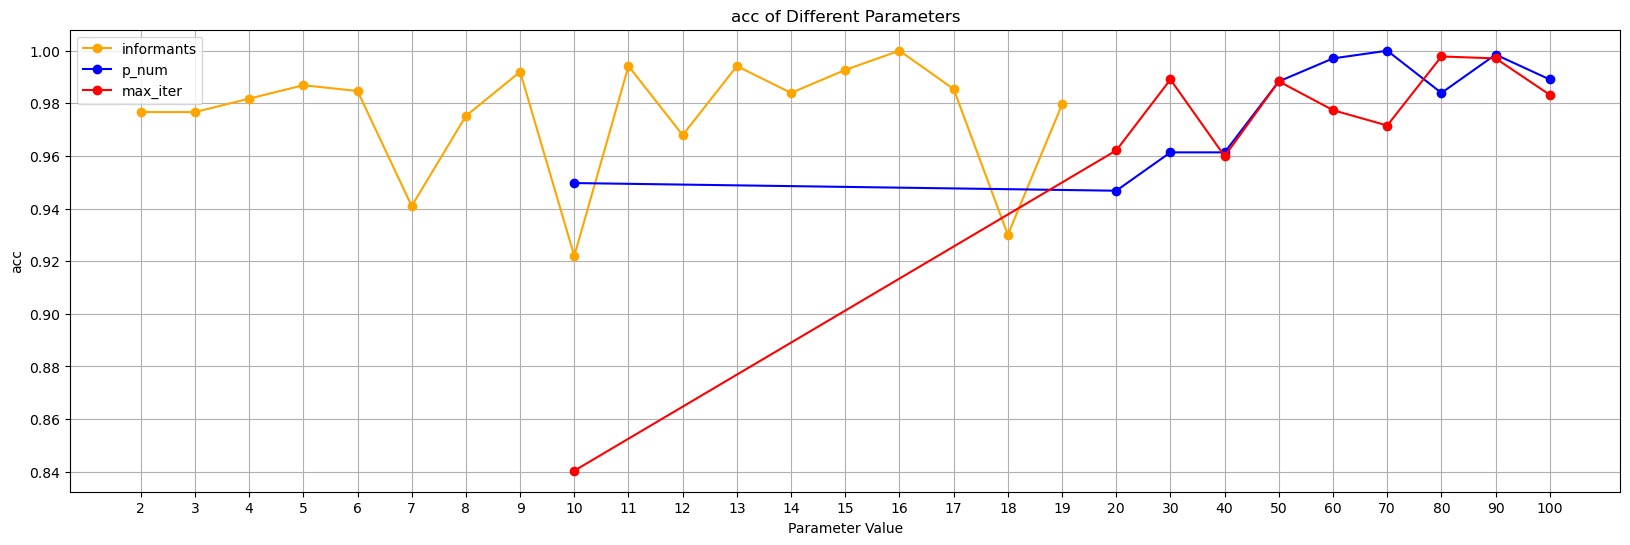

In [96]:
nn = ANN_Network(4,[3,3],2,relu,softmax)
#  compare different p_num(swarm size) in pso based on the other baseline parameters
score_dict1={}
for p_num in range(10,110,10):
    score=train_ANN(PSO_informants,nn,obj_func,p_num,50,5,0.5,0.5,0.5)
    score_dict1[str(p_num)]=score
p_nums = list(score_dict1.keys())
scores1 = list(score_dict1.values())

# compare different max iter in pso based on the other baseline parameters
score_dict2={}
for max_iter in range(10,110,10):
    score=train_ANN(PSO_informants,nn,obj_func,30,max_iter,5,0.5,0.5,0.5)
    score_dict2[str(max_iter)]=score
max_iters = list(score_dict2.keys())
scores2 = list(score_dict2.values())

# compare different number of informants in pso based on the other baseline parameters
score_dict3={}
for n_informants in range(2,20):
    score=train_ANN(PSO_informants,nn,obj_func,30,50,n_informants,0.5,0.5,0.5)
    score_dict3[str(n_informants)]=score
informants = list(score_dict3.keys())
scores3 = list(score_dict3.values())

# plot trends
plt.figure(figsize=(20, 6))
plt.plot(informants, scores3, marker='o', color='orange', label='informants')
plt.plot(p_nums, scores1, marker='o', color='blue', label='p_num')
plt.plot(max_iters, scores2, marker='o', color='red', label='max_iter')

plt.title("acc of Different Parameters")
plt.xlabel('Parameter Value')
plt.ylabel('acc')
plt.grid(True)
plt.legend()
plt.show()

# 4, compare different w in pso

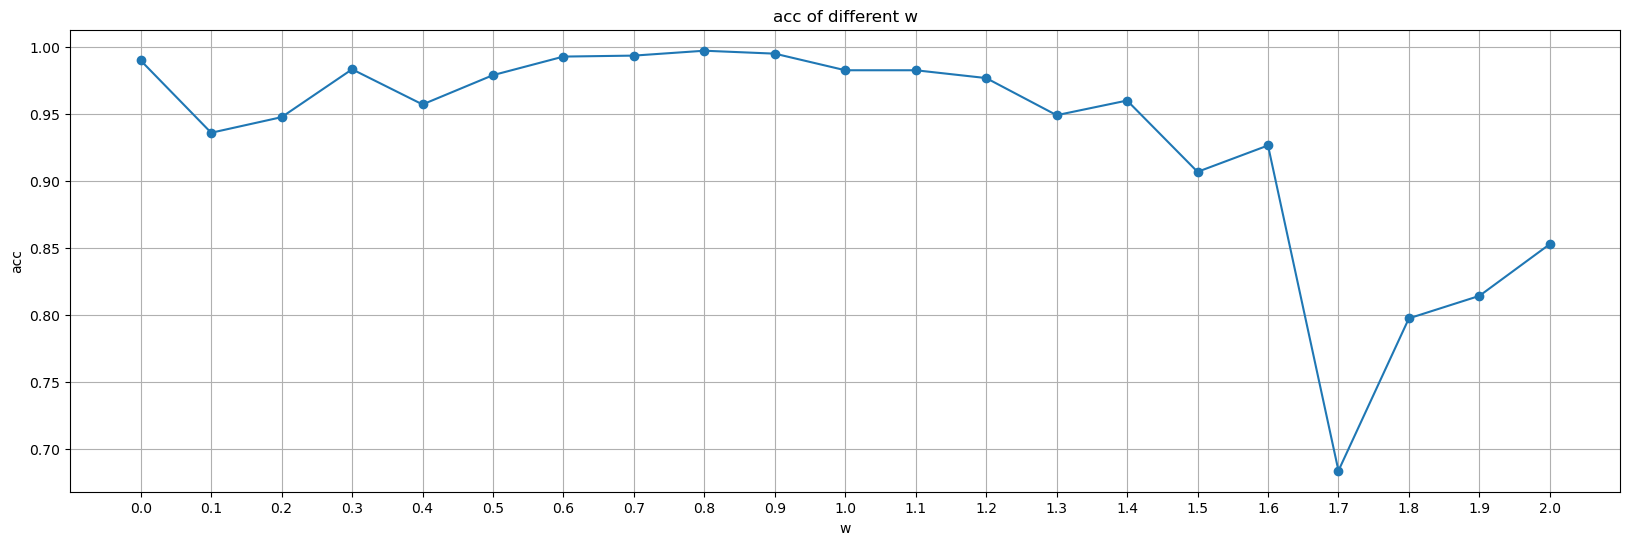

In [97]:
# # compare different w in pso based on the other baseline parameters
nn = ANN_Network(4,[3,3],2,relu,softmax)
w_list= np.arange(0, 2.1, 0.1)
score_dict={}
for w in w_list:
    score=train_ANN(PSO_informants,nn,obj_func,30,50,5,w,0.5,0.5)
    score_dict[str(w)]=score
ws = [float(w) for w in score_dict.keys()]
scores_w = list(score_dict.values())

plt.figure(figsize=(20, 6))
plt.plot(ws, scores_w, marker='o')
plt.title("acc of different w")
plt.xlabel('w')
plt.ylabel('acc')
plt.grid(True)
plt.xticks(np.arange(min(ws), max(ws)+0.1, 0.1))
plt.show()

# 5, compare different c1,c2 (acceleration coefficients) in pso


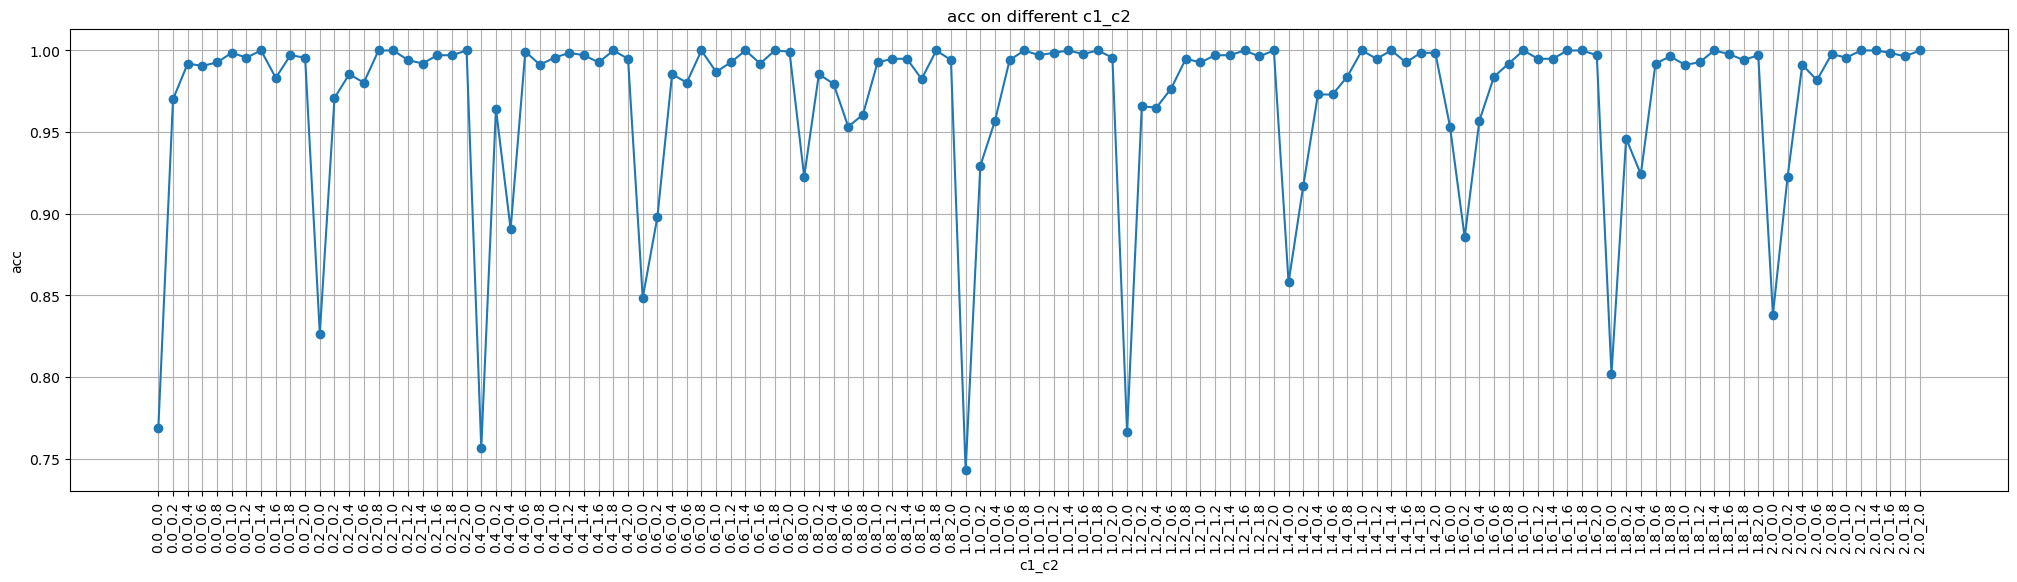

In [110]:
# compare different combinations of c1,c2 (acceleration coefficients) in pso
nn = ANN_Network(4,[3,3],2,relu,softmax)
c1_list= np.arange(0, 2.2, 0.2)
c2_list=np.arange(0, 2.2, 0.2)
score_dict_c={}
c_combinations = [f"{c1:.1f}_{c2:.1f}" for c1 in c1_list for c2 in c2_list]
for combinations in c_combinations:
    c1,c2=combinations.split("_")
    score=train_ANN(PSO_informants,nn,obj_func,30,50,5,0.5,float(c1),float(c2))
    score_dict_c[c1+'_'+c2]=score
        
c_combinations = list(score_dict_c.keys())
scores_c1_c2 = list(score_dict_c.values())

plt.figure(figsize=(25, 6))
plt.plot(c_combinations, scores_c1_c2, marker='o')
plt.title("acc on different c1_c2")
plt.xlabel('c1_c2')
plt.ylabel('acc')
plt.grid(True)
plt.xticks(rotation=90)
plt.show()

# 6, compare different pso variants

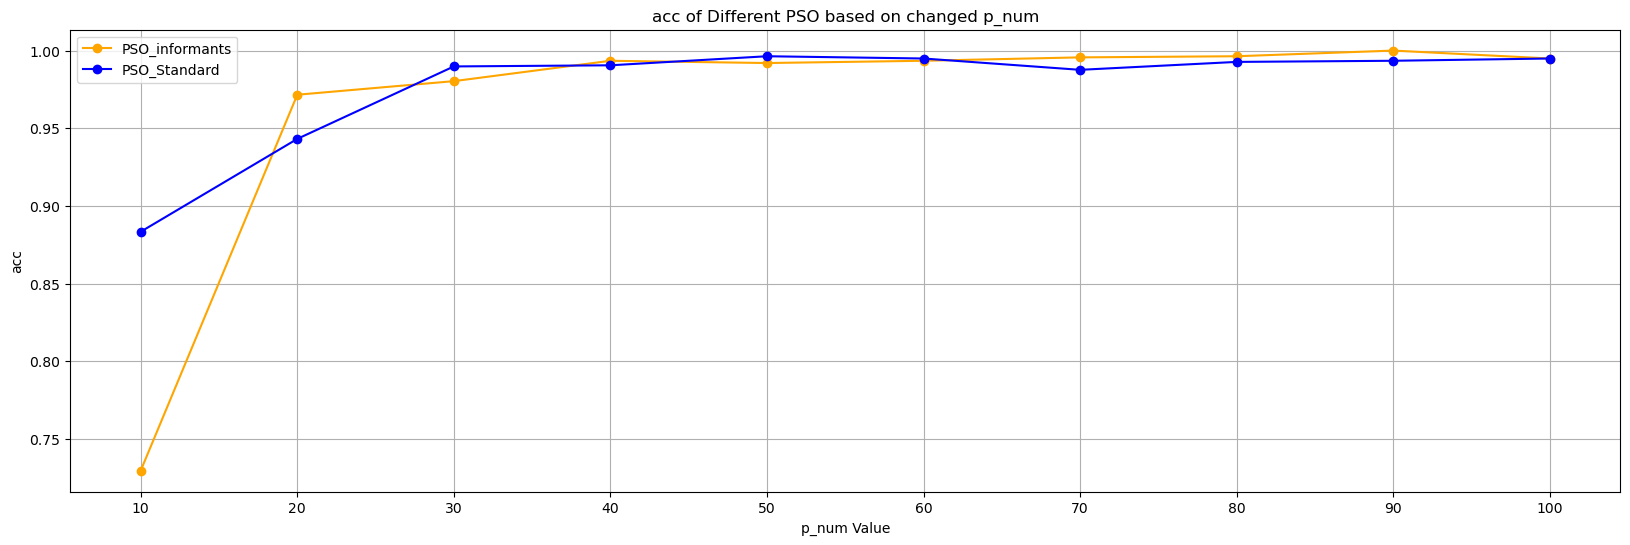

In [101]:
# compare different pso variants based different p_num.
nn = ANN_Network(4,[3,3],2,relu,softmax) 
score_dict_infor={}
score_dict_standard={}
for p_num in range(10,110,10):
    score_informants=train_ANN(PSO_informants,nn,obj_func,p_num,50,5,0.5,0.5,0.5)
    score_standard=train_ANN(PSO_Standard,nn,obj_func,p_num,50,None,0.5,0.5,0.5)
    score_dict_infor[str(p_num)]=score_informants
    score_dict_standard[str(p_num)]=score_standard
    
p_nums_infor = list(score_dict_infor.keys())
p_nums_standard=list(score_dict_standard.keys())

scores_infor = list(score_dict_infor.values())
scores_standard = list(score_dict_standard.values())

plt.figure(figsize=(20, 6))
plt.plot(p_nums_infor, scores_infor, marker='o', color='orange', label='PSO_informants')
plt.plot(p_nums_standard, scores_standard, marker='o', color='blue', label='PSO_Standard')

plt.title("acc of Different PSO based on changed p_num")
plt.xlabel('p_num Value')
plt.ylabel('acc')
plt.grid(True)
plt.legend()
plt.show()
